IMPORT LIBRERIE

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import itertools
import os
import shutil
from random import randint
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


LOAD MODEL

In [2]:
#load model dalla cartella Models
json_file = open('..\\Models\\model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("..\\Models\\model.h5")
print("Loaded model from disk")

Loaded model from disk


TESTING

In [3]:
train_path = '..\\Data\\Prepared\\train'
valid_path = '..\\Data\\Prepared\\valid'
test_path = '..\\Data\\Prepared\\test'

In [4]:
#applicazione image processing
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
.flow_from_directory(directory=train_path, target_size=(299,299), classes=['ok','nok'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=(299,299), classes=['ok','nok'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
.flow_from_directory(directory=test_path,  target_size=(299,299), classes=['ok','nok'], batch_size=10, shuffle=False)

Found 800 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
assert train_batches.n == 800
assert valid_batches.n == 100
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [6]:
X_test = test_batches
y_test = test_batches.classes

In [7]:
predictions = loaded_model.predict(x=X_test, verbose=0)

In [8]:
#probabilità di appartenere a 0 o 1
for i in predictions:
    print(i)

[9.9965918e-01 3.4084893e-04]
[0.9985405  0.00145953]
[9.9911660e-01 8.8341325e-04]
[0.9989786  0.00102143]
[0.9989786  0.00102143]
[0.9847792 0.0152208]
[9.990146e-01 9.853630e-04]
[0.99004024 0.00995977]
[0.9847792 0.0152208]
[9.9999976e-01 2.1051738e-07]
[9.9999535e-01 4.6118157e-06]
[0.99004024 0.00995977]
[9.997929e-01 2.071838e-04]
[9.9972969e-01 2.7029458e-04]
[1.0000000e+00 3.5596563e-09]
[1.0000000e+00 3.5596563e-09]
[9.9972969e-01 2.7029458e-04]
[9.9919981e-01 8.0022356e-04]
[9.991825e-01 8.174100e-04]
[9.997929e-01 2.071838e-04]
[9.991825e-01 8.174100e-04]
[0.99854124 0.00145878]
[1.0000000e+00 1.3947375e-08]
[9.9920636e-01 7.9369708e-04]
[9.9980038e-01 1.9958313e-04]
[9.9946135e-01 5.3868425e-04]
[1.0000000e+00 3.7686854e-09]
[9.9920636e-01 7.9369708e-04]
[9.9966121e-01 3.3883922e-04]
[9.9980038e-01 1.9958313e-04]
[9.9946135e-01 5.3868425e-04]
[9.9980038e-01 1.9958313e-04]
[9.9918216e-01 8.1786781e-04]
[9.9918216e-01 8.1786781e-04]
[0.99854124 0.00145878]
[9.9972969e-01 2.7

In [9]:
#definizione classe di appartenenza predizione con threshold pari a 0.5
rounded_predictions = predictions[:,1]
rounded_predictions = np.where(rounded_predictions>0.5, 1, 0)
for i in rounded_predictions:
    print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
0


In [10]:
y_pred=rounded_predictions

EVALUATION

1)CONFUSION MATRIX

In [11]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

In [13]:
cm_plot_labels = ['ok_image','nok_image']

Confusion matrix, without normalization
[[50  0]
 [ 3 47]]


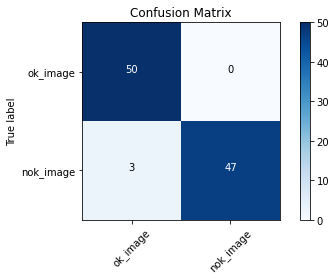

In [14]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

2) ACCURACY, PRECISION, F1-SCORE E RECALL

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        50
           1       1.00      0.94      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



3) ROC CURVE

10/10 [==============================] - 11s 1s/step


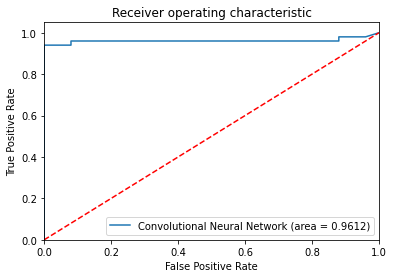

In [16]:
cnn_roc_auc = roc_auc_score(y_test, loaded_model.predict(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, loaded_model.predict(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Convolutional Neural Network (area = %0.4f)' % cnn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()